Osasto 1: Keskimääräinen oleskeluaika 510 sekuntia
Osasto 2: Keskimääräinen oleskeluaika 546 sekuntia
Osasto 3: Keskimääräinen oleskeluaika 475 sekuntia
Osasto 4: Keskimääräinen oleskeluaika 548 sekuntia


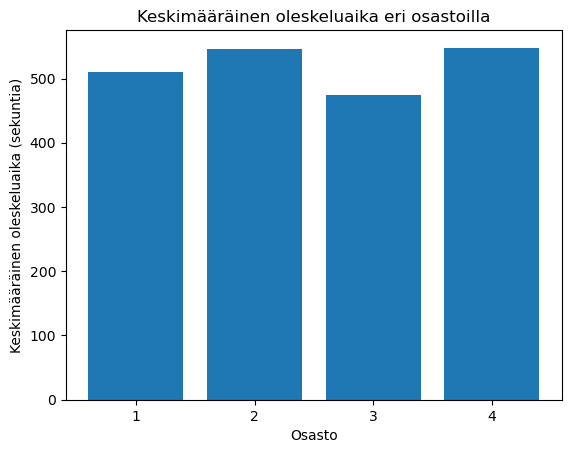

In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

from database_connection import create_conn

def get_sensor_data_with_timestamps():
    conn = create_conn()
    query = "SELECT timestamp, sensor_id, x, y FROM SensorData LIMIT 1000000;"

    with conn.cursor(pymysql.cursors.DictCursor) as cursor:
        cursor.execute(query)
        result = cursor.fetchall()

    conn.close()

    if result:
        columns = ["timestamp", "sensor_id", "x", "y"]
        df = pd.DataFrame(result, columns=columns)
        return df
    else:
        return pd.DataFrame()

rectangles = pd.DataFrame({
    'x1': [1000, 5000, 1500, 5000],
    'y1': [0, 0, 2250, 2250],
    'x2': [5000, 10400, 5000, 10400],
    'y2': [2250, 2250, 5200, 5200],
})

df = get_sensor_data_with_timestamps()
average_dwell_times = []

for i, row in rectangles.iterrows():
    department = df.loc[(df['x'] >= row['x1']) & (df['x'] <= row['x2']) & (df['y'] >= row['y1']) & (df['y'] <= row['y2'])].copy()
    department['timestamp'] = pd.to_datetime(department['timestamp'])
    department = department.sort_values('timestamp')
    department['time_diff'] = department.groupby('sensor_id')['timestamp'].diff()

    dwell_times = []
    for sensor_id, sensor_data in department.groupby('sensor_id'):
        # Filter data where each sensor has at least 10 records in the department
        if len(sensor_data) < 10:
            continue

        # Check for new visits
        new_visit = sensor_data['time_diff'] > pd.Timedelta(minutes=10)
        sensor_data.loc[new_visit, 'visit_id'] = range(1, new_visit.sum() + 1)
        sensor_data['visit_id'].fillna(method='ffill', inplace=True)

        # Calculate dwell time for each visit
        for visit_id, visit_data in sensor_data.groupby('visit_id'):
            if len(visit_data) >= 10:
                dwell_time = visit_data['timestamp'].iloc[-1] - visit_data['timestamp'].iloc[0]
                dwell_times.append(dwell_time.total_seconds())

    average_dwell_time = int(np.round(pd.Series(dwell_times, dtype=float).mean()))
    average_dwell_times.append(average_dwell_time)
    print(f"Osasto {i + 1}: Keskimääräinen oleskeluaika {average_dwell_time} sekuntia")

plt.bar(range(1, len(average_dwell_times) + 1), average_dwell_times)
plt.xticks(range(1, len(average_dwell_times) + 1))
plt.xlabel("Osasto")
plt.ylabel("Keskimääräinen oleskeluaika (sekuntia)")
plt.title("Keskimääräinen oleskeluaika eri osastoilla")
plt.show()


Tavoitteena saada asiakkaalle ymmärrys missä osioissa kauppaa asiakas viettää eniten aikaa